In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

In [5]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
%matplotlib inline

In [6]:
data = pd.read_csv('/content/conversion_project.csv')

In [7]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [9]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [10]:
for col in data.columns:
  uniques = sorted(data[col].unique())
  print('{0:20s}{1:5d}\t'.format(col, len(uniques)), uniques[:5])

country                 4	 ['China', 'Germany', 'UK', 'US']
age                    60	 [17, 18, 19, 20, 21]
new_user                2	 [0, 1]
source                  3	 ['Ads', 'Direct', 'Seo']
total_pages_visited    29	 [1, 2, 3, 4, 5]
converted               2	 [0, 1]


In [11]:
# remove outliers: age should under 100

data[data['age']> 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [12]:
# remove these 2 age outliers
data = data[data['age']< 100]

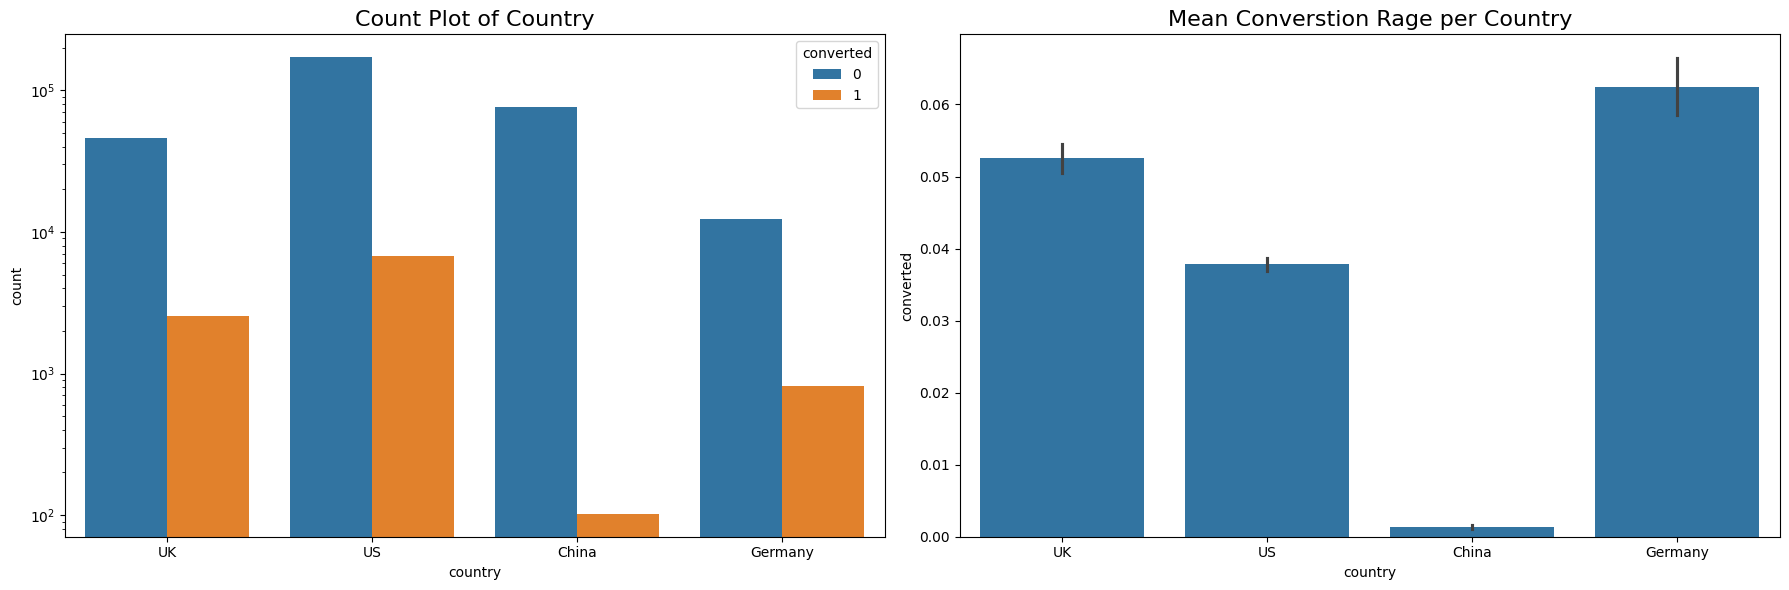

In [14]:
# EDA: conversition for different countries

country_grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax= ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax= ax[1])
ax[1].set_title('Mean Converstion Rage per Country',fontsize=16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mean Convertion ')

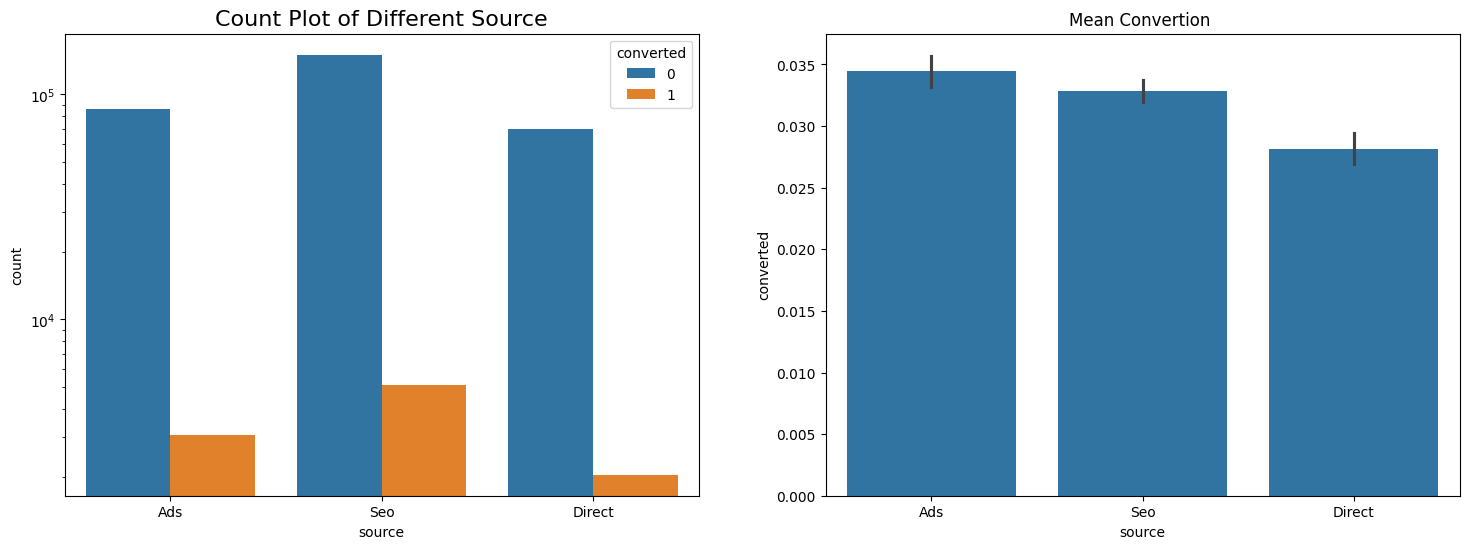

In [21]:
# convertion for different sources

source_grouped = data[['source','converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Source', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Convertion ')

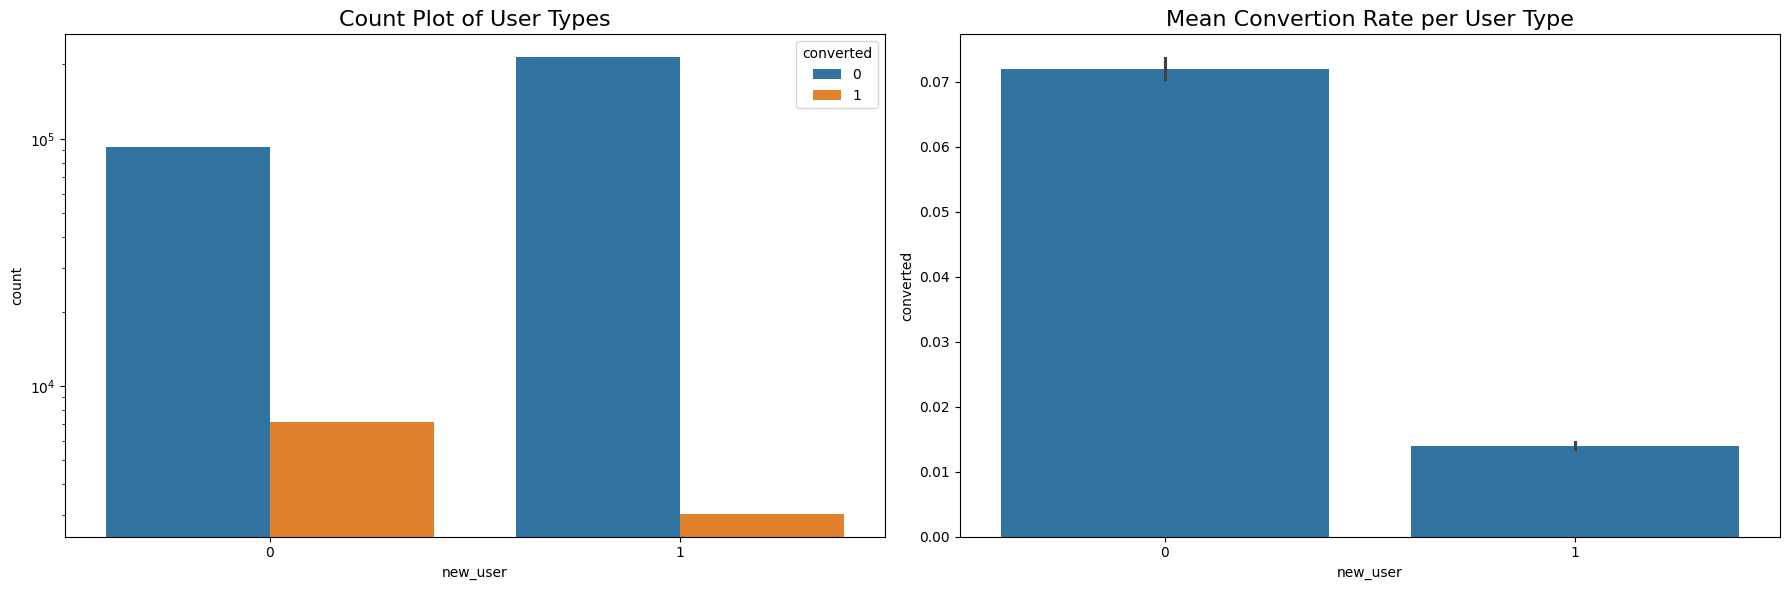

In [20]:
# convertion for different user type

grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y= 'converted', data=data, ax=ax[1])
ax[1].set_title('Mean Convertion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

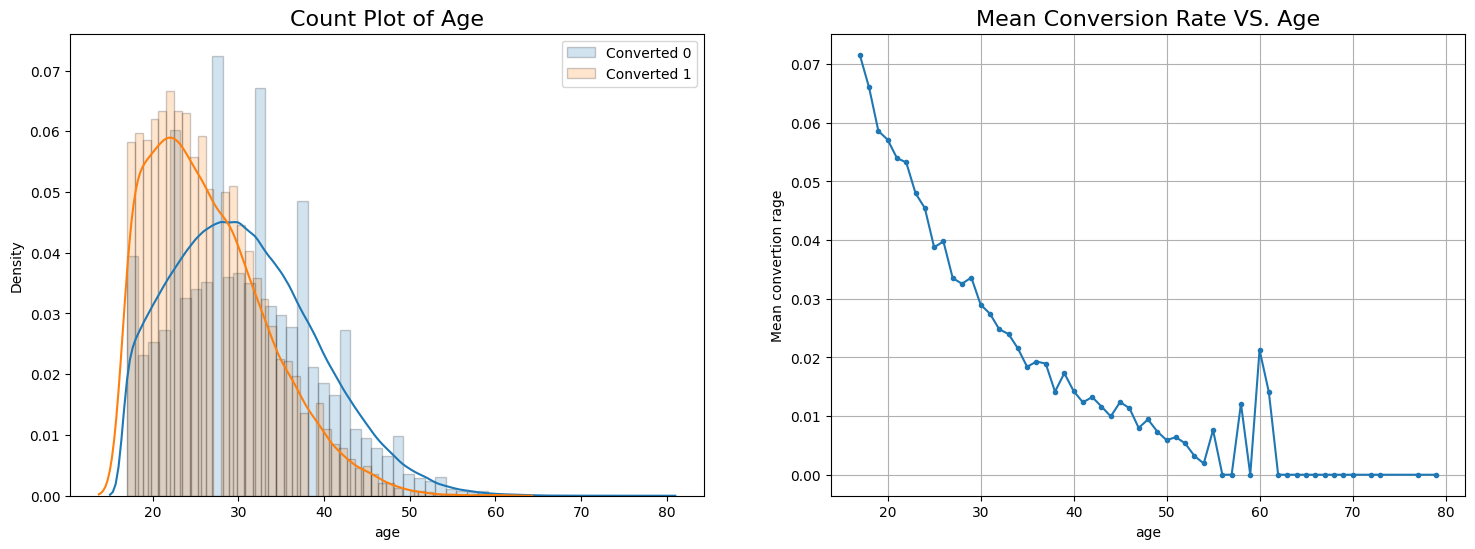

In [46]:
# convertion for different age

grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(data[data['converted']==0]['age'], label='Converted 0',
            ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted']==1]['age'], label ='Converted 1',
            ax=ax[0], hist_kws=hist_kws)

ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate VS. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rage')
ax[1].grid(True)
plt.show()

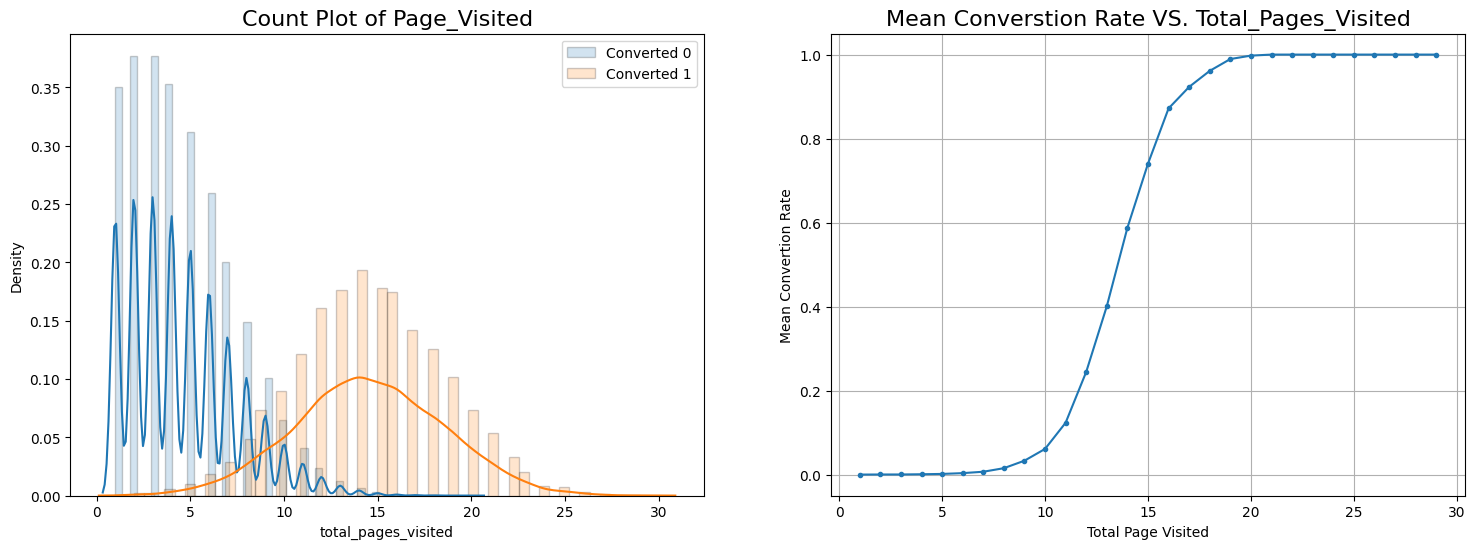

In [34]:
# convertion for page_visted

grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
#hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.distplot(data[data['converted']==0]['total_pages_visited'], label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted']==1]['total_pages_visited'], label='Converted 1', ax=ax[0], hist_kws= hist_kws)
ax[0].set_title('Count Plot of Page_Visited', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Converstion Rate VS. Total_Pages_Visited', fontsize=16)
ax[1].set_xlabel('Total Page Visited')
ax[1].set_ylabel('Mean Convertion Rate')
ax[1].grid(True)
plt.show()

In [35]:
# machine learning: initialized h2o cluster

h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9u4r_xpn
  JVM stdout: /tmp/tmp9u4r_xpn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9u4r_xpn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_unknownUser_y3qir2
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [37]:
# transform to H2o DataFrame and ensure target variable is categorical

h2o_df = H2OFrame(data)
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()
h2o_df.show_summary()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [40]:
# split into 80% train and 20% test

strat_split = h2o_df['converted'].stratified_split(test_frac=0.20, seed=42)
train = h2o_df[strat_split=='train']
test = h2o_df[strat_split =='test']

feature =['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [41]:
#Build random forest model

model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20,mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1707960683539_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         3.32346e+06            19           20           19.98         1750          3196          2637.02

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11960045609050604
RMSE: 0.3458329887250579
LogLoss: 0.381646303234454
Mean Per-Class Error: 0.04197514868941298
AUC: 0.9925903478983304
AUCPR: 0.9914006004419725
Gini: 0.9851806957966609

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.030908573781642894
       0       1       Error    Rate
-----  ------  ------  -------  ------------------
0      232278  12522   0.0512   (12522.0/244800.0)
1      8029    236770  0.0328   (8029.0/244799.0)
Total  240307  249292  0.042    (20551.0/489599.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0309086    0.958406  373
max f2                       0.00872023   0.976121  388
max f0point5                 0.101157     0.961549  343
max accuracy                 0.0359424    0.958076  371
max precision                0.98473      0.999392  10
max recall                   0.00238872   1         394
max specificity              0.999203     0.999996  0
max absolute_mcc             0.0309086    0.916204  373
max min_per_class_accuracy   0.0421395    0.957071  368
max mean_per_class_accuracy  0.0359424    0.958076  371
max tns                      0.999203     244799    0
max fns                      0.999203     243968    0
max fps                      7.24222e-05  244800    399
max tps                      0.00238872   244799    394
max tnr                      0.999203     0.999996  0
max fnr                      0.999203     0.996605  0
max fpr                      7.24222e-05  1         399
max tpr                      0.00238872   1         394

Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.79 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.993784           1.99837   1.99837            0.999183         0.996374     0.999183                    0.996374            0.0199837       0.0199837                  99.837    99.837             0.0199674
2        0.0200021                   0.989165           1.99837   1.99837            0.999183         0.991417     0.999183                    0.993896            0.0199878       0.0399716                  99.837    99.837             0.0399389
3        0.0300021                   0.985375           1.99919   1.99864            0.999592         0.987256     0.999319                    0.991682            0.0199919       0.0599635                  99.9187   99.8643            0.0599226
4        0.0400001                   0.981611           1.99755   1.99837            0.998774         0.98352      0.999183                    0.989642            0.0199715       0.079935                   99.7553   99.837             0.0798696
5        0.0500001                   0.977452           1.99755   1.99821            0.998775     

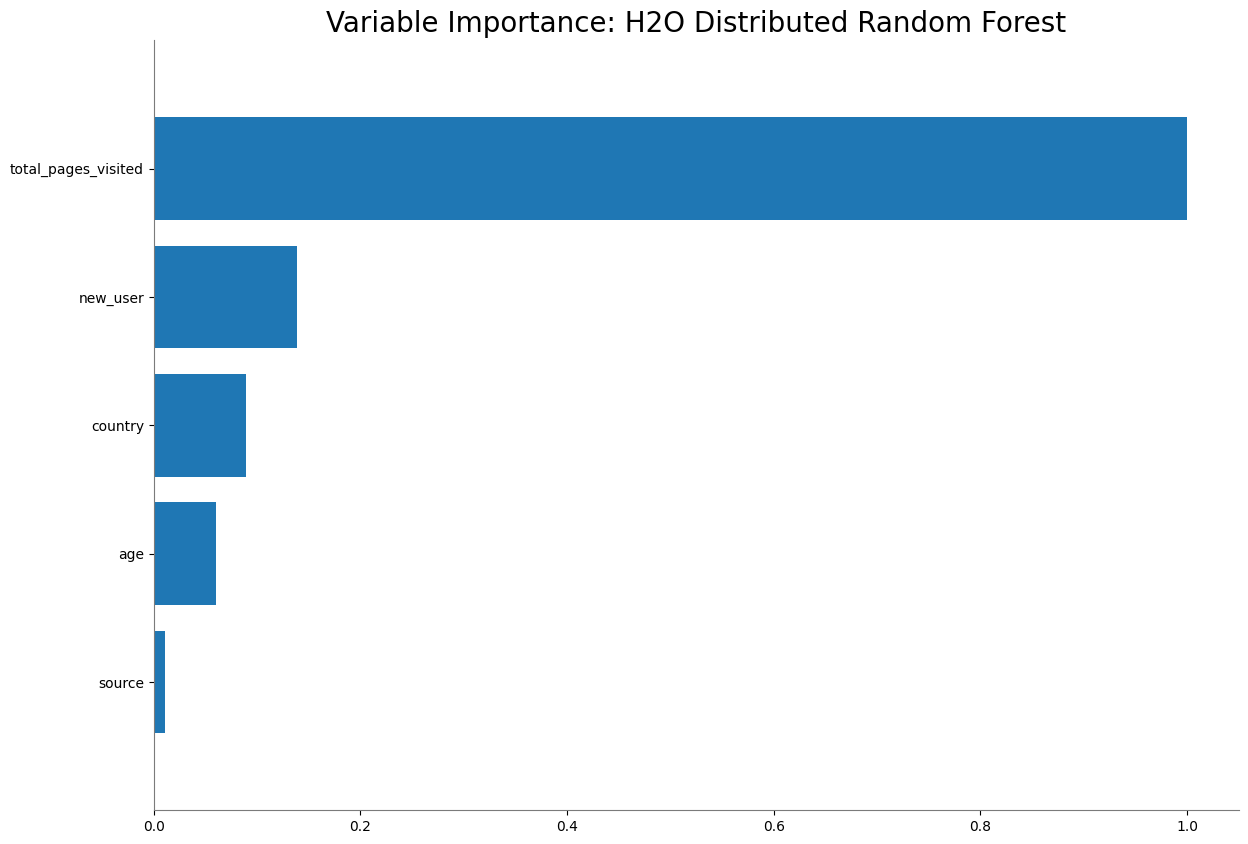

<Figure size 640x480 with 0 Axes>

In [42]:
model.varimp_plot()

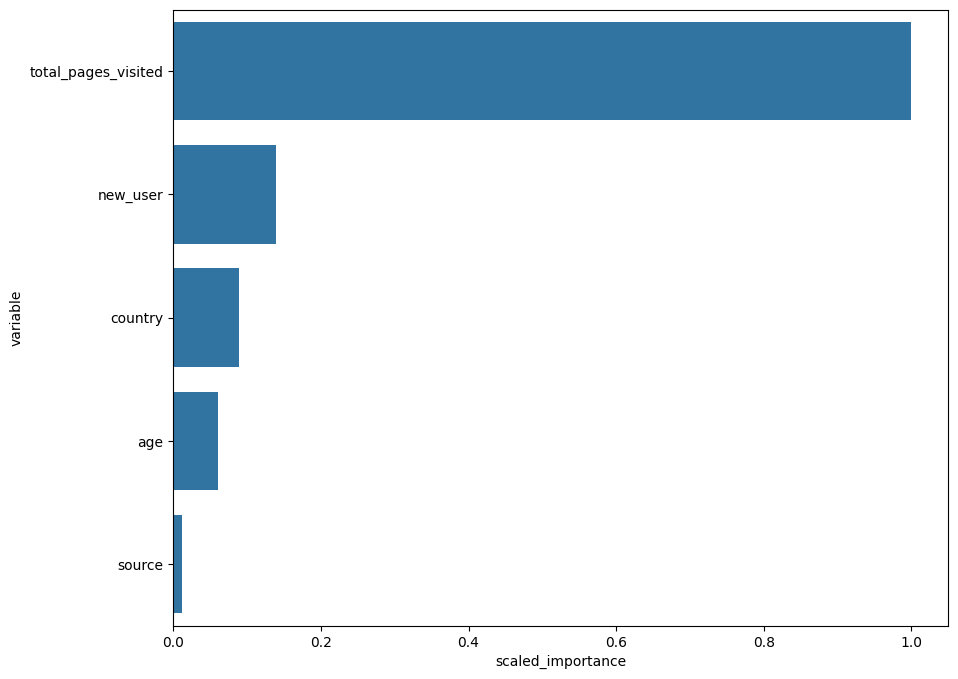

In [46]:
# feature importance

importance= model.varimp(use_pandas=True)
fig, ax= plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [48]:
# make prediction

train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [49]:
# classification report

print(classification_report(y_true=test_true, y_pred=(test_pred >0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     61200
           1       0.84      0.64      0.73      2040

    accuracy                           0.98     63240
   macro avg       0.92      0.82      0.86     63240
weighted avg       0.98      0.98      0.98     63240



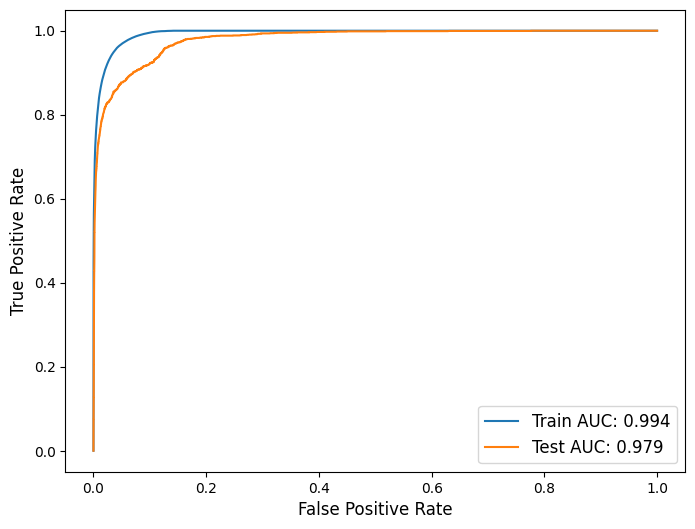

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


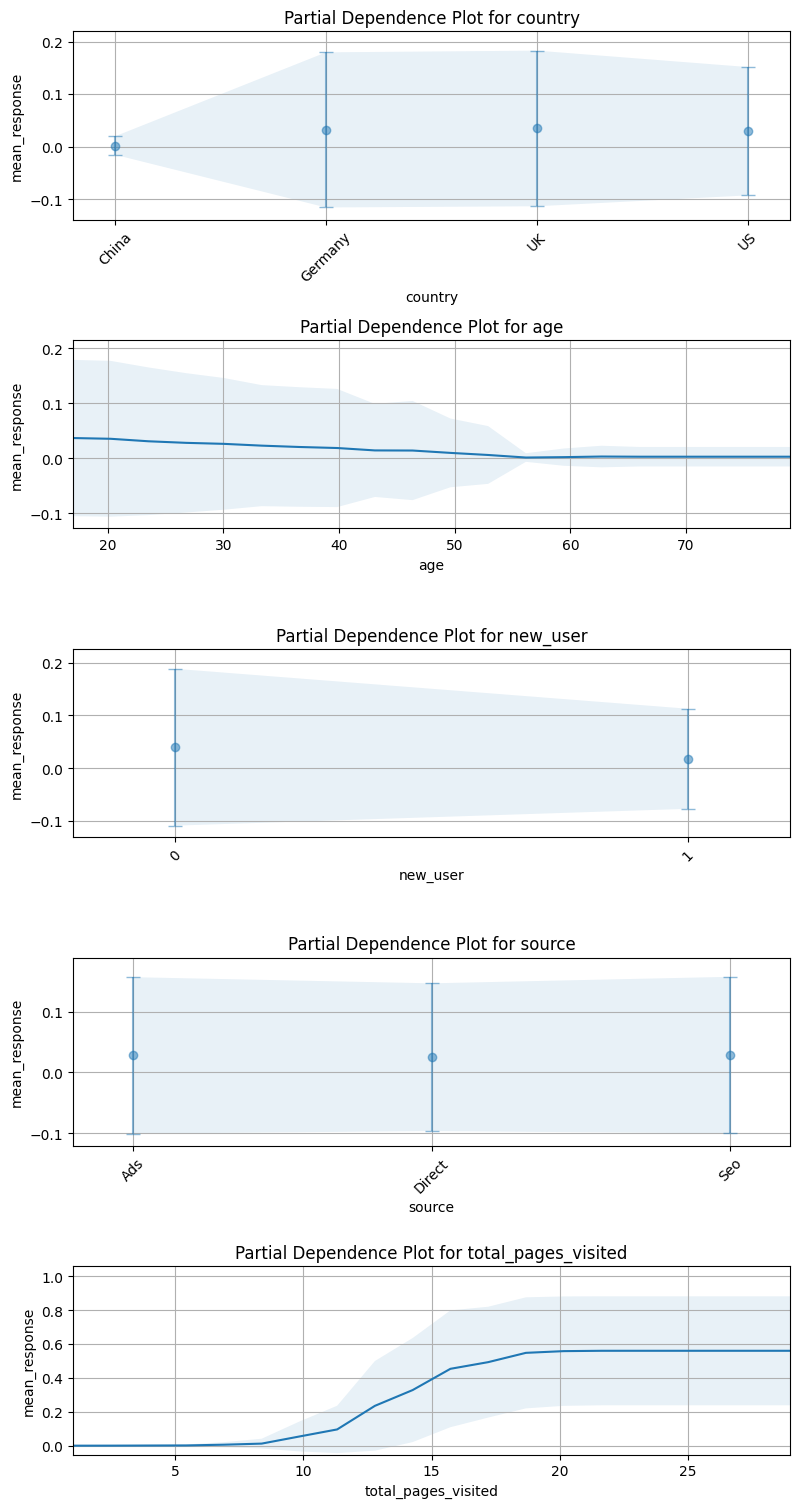

In [51]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))


In [ ]:
# Shutdown h2o instance

h2o.cluster().shutdown()